# Red Wine Quality Analysis

I first did the analysis, but then, while looking for reference and to see what was done, I noticed that balancement wasn't something touched upon.

It's going to be a little straight-forward, but I'll try to give insight to the extent of my knowledge. Sooo... welcome to the ride! Because it's going to be a messy one..

## Introduction

This notebook is thought to be on Kaggle, hence why there are so many heading ones.

### References

- https://www.kaggle.com/datasets/uciml/red-wine-quality-cortez-et-al-2009

### Context

The two datasets are related to red and white variants of the Portuguese "Vinho Verde" wine. For more details, consult the reference [Cortez et al., 2009]. Due to privacy and logistic issues, only physicochemical (inputs) and sensory (the output) variables are available (e.g. there is no data about grape types, wine brand, wine selling price, etc.).

These datasets can be viewed as classification or regression tasks. The classes are ordered and not balanced (e.g. there are much more normal wines than excellent or poor ones). 

### Features

- fixed acidity
- volatile acidity
- citric acid
- residual sugar
- chlorides
- free sulfur dioxide
- total sulfur dioxide
- density
- pH
- sulphates
- alcohol
- **[target]** quality (score between 0 and 10) 

## Initialization

I, personally, always like to have some configuration variables at the top of my notebook, just in case I want to quickly change something.

In [1]:
RANDOM_SEED = 0 #@param {type:'integer'}
DEV_RANDOM_SEED = 42 #@param {type:'integer'}

DEVELOPMENT_ENVIRONMENT = True #@param {type:'boolean'}

if DEVELOPMENT_ENVIRONMENT:
  RANDOM_SEED = DEV_RANDOM_SEED

### Imports

While doing data science, or analysis, this ones are the most basic libraries, data engineering uses similar but also extra libraries. And a typing class, because typing is a must whenever possible.

In [2]:
import pandas as pd
import numpy as np
np.random.seed(RANDOM_SEED)
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil, floor
from typing import List

### Load the dataset

The dataset will be downloaded from Kaggle, but we'll need to authenticate ourselves

We need our kaggle.json, I'll mount my drive, but no need to do so if you've already authenticated yourself locally

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Installing the official kaggle librarie and preparing the authencation, as aforementioned, skip this step if you've already done this

In [4]:
%pip install kaggle -q
%cp "/content/drive/MyDrive/Colab Notebooks/Kaggle/jofaval-kaggle.json" "kaggle.json"
%mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Download and unzip, all at once, the wanted dataset, for this project, the wine quality dataset.

In [5]:
!kaggle datasets download "uciml/red-wine-quality-cortez-et-al-2009" -q --unzip

Once we've done all that, we can finally load our dataset, and we'll check that everything's fine but printing the number of rows and columns

In [6]:
dataframe = pd.read_csv('winequality-red.csv')
dataframe.shape

(1599, 12)

## Helpers

This section will appear one more time, it's a section for the utility functions, helpers, that will be used for the current section

Notebooks are HTML, and so they tend to display the content algined to the left, but I feel that it's visually more appealing to center the content.

Source: https://stackoverflow.com/questions/60866073/how-can-i-align-outputs-charts-in-google-colab

In [7]:
from IPython.display import HTML, display

def center_output():
  display(HTML("""
  <style>
  #output-body {
      display: flex;
      align-items: center;
      justify-content: center;
      flex-direction: column
  }
  </style>
  """))

# Exploratory Data Analysis

This step, it's what truly makes data science, data science, without a good exploratory data analysis, which I'm not claiming that this one, you're done for.

When entering this section, the most common aspect is that you'll have no idea what the data is about, the idea is to understand the data quite a bit, try to detect any sort of pattern that may help us, remove any abnormaly, etc.

In [8]:
dataframe.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


## Missing values

A missing value is a null-value, or as pandas calls it, Not Acknowledged, whenever in our data some field was not completed, an empty value that should be there.

For this project, we don't have any, which is far from common, aside from educational datasets.

In [9]:
dataframe.isna().sum().sum() / (len(dataframe) * dataframe.shape[1])

0.0

The percentage of missing values per feature

In [10]:
dataframe.isna().sum() * 100 / len(dataframe)

fixed acidity           0.0
volatile acidity        0.0
citric acid             0.0
residual sugar          0.0
chlorides               0.0
free sulfur dioxide     0.0
total sulfur dioxide    0.0
density                 0.0
pH                      0.0
sulphates               0.0
alcohol                 0.0
quality                 0.0
dtype: float64

We can not only visualize in a grid view, we could also use a heatmap to easily identify where are the missing values, and if there's any pattern to it, or even if slice the dataframe is worth it.

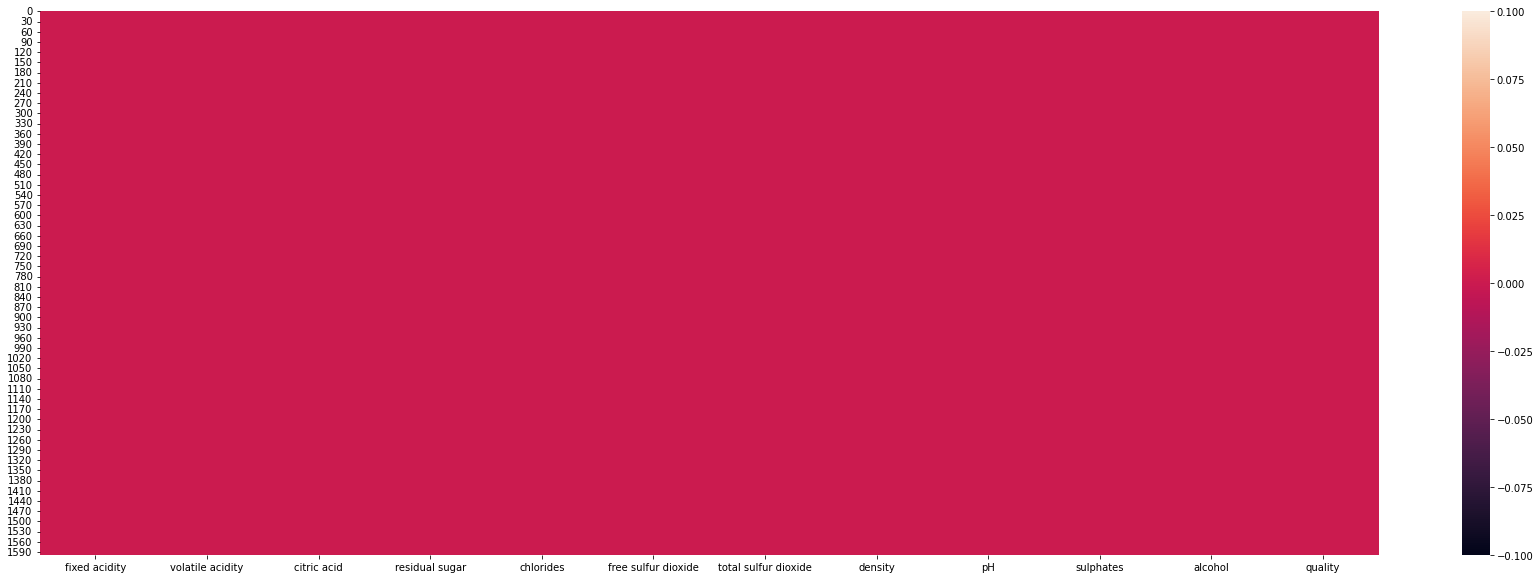

In [11]:
center_output()
plt.figure(figsize=(30, 10))
sns.heatmap(dataframe.isna())

## Abnormal values

When analyzing data, at times, we may be working with real values, not feature engineered ones (the ones we create for ourselves).

For example, alcohol, we know that it may be 0, but no less than that. If that were to be a case, we'd have to remove, or "manually" fix them.

In [12]:
dataframe.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
fixed acidity,1599.0,8.319637,1.741096,4.60000,7.1000,7.90000,9.200000,15.90000
volatile acidity,1599.0,0.527821,0.179060,0.12000,0.3900,0.52000,0.640000,1.58000
citric acid,1599.0,0.270976,0.194801,0.00000,0.0900,0.26000,0.420000,1.00000
residual sugar,1599.0,2.538806,1.409928,0.90000,1.9000,2.20000,2.600000,15.50000
chlorides,1599.0,0.087467,0.047065,0.01200,0.0700,0.07900,0.090000,0.61100
free sulfur dioxide,1599.0,15.874922,10.460157,1.00000,7.0000,14.00000,21.000000,72.00000
total sulfur dioxide,1599.0,46.467792,32.895324,6.00000,22.0000,38.00000,62.000000,289.00000
density,1599.0,0.996747,0.001887,0.99007,0.9956,0.99675,0.997835,1.00369
pH,1599.0,3.311113,0.154386,2.74000,3.2100,3.31000,3.400000,4.01000
sulphates,1599.0,0.658149,0.169507,0.33000,0.5500,0.62000,0.730000,2.00000


## Standarization

Standarization, preprocessing as some call it, remapping, whatever you want to call it. We need to transform our data from raw to quality data, it may be strings, it may be vectors, or even numbers that must undergo some algebraical operation (radian conversion, sin and cos, etc.)

Once again, the most common thing is having to remap, at least, a couple of features, but all of the values are as they should, the independent features are floats, and our target feature is an integer.

In [13]:
dataframe.dtypes

fixed acidity           float64
volatile acidity        float64
citric acid             float64
residual sugar          float64
chlorides               float64
free sulfur dioxide     float64
total sulfur dioxide    float64
density                 float64
pH                      float64
sulphates               float64
alcohol                 float64
quality                   int64
dtype: object

## Correlation

The correlation is the co-dependency between a pair of features, which, in other words, translates to how similar are two values statistically speaking.

It's common, and wanted, that one value changes whenever another does, in fact, that's what we're looking forward with an analysis, to detect those kind of values with the target feature. But when that correlation gets too high, one of them is adding noise.

There's a rule that above 50% of correlation, it's too much, but at times it's better not to apply it. And if we were to delete a feature that's too correlated, there isn't much guide about which one to drop, it's up to you at the end of the day.

For this project, almost 70% of correlation is a lot, but we assume that the values, while similar (they're different aspects of the acidity) are not the same.

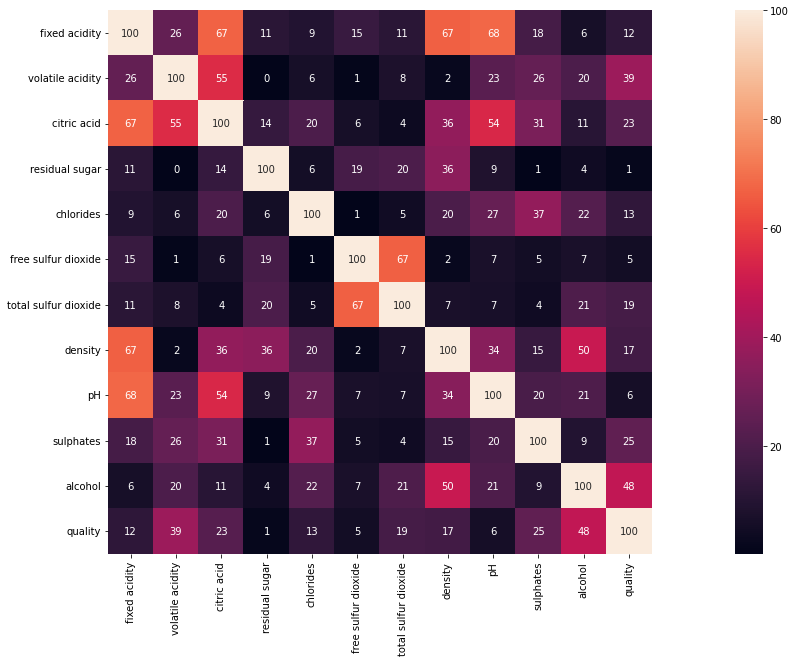

In [14]:
center_output()
plt.figure(figsize=(30, 10))
sns.heatmap(dataframe.corr().abs() * 100, annot=True, fmt='.0f', square=True)

I've used an absolute correlation because it helps identify too highly correlated values. and i've also increased the values to percentage integers, it helps the eye look out for two digits numbers and not try to do any funny conversion in time.

## Dependant explainability and insights

We can also plot, and we should, the direct correlation between one feature and the target feature.

My guide is, usually, whenever a shape forms, that's an indicator of correlation, the more shape and distortion, the more correlation, the more uniformity in the given shape, the less it contributes.

Kernel Density Estimate, or KDE, it's a good visualization for the distribution while analyzing the values, it creates a shape, but we can get some insights from this.

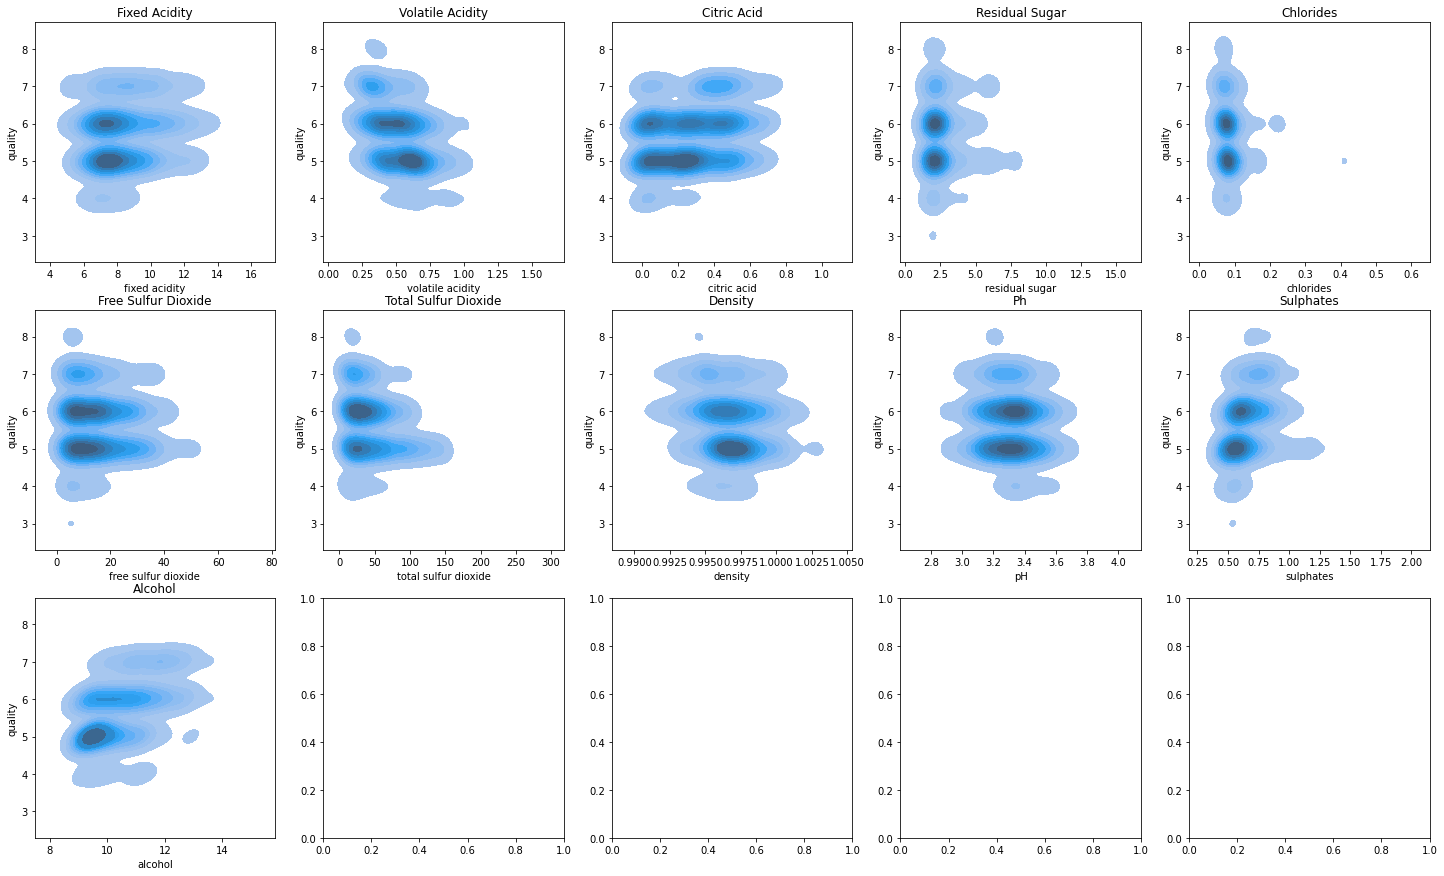

In [15]:
columns = [ col for col in dataframe.columns if col not in ['quality'] ]
n_cols = 5
n_rows = ceil(len(columns) / n_cols)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 5 * n_rows))
for index, col in enumerate(columns):
  ax = axes[index // n_cols, int(index % n_cols)]
  # sns.histplot(data=dataframe, x=col, y='quality', ax=ax)
  # sns.scatterplot(data=dataframe, x=col, y='quality', ax=ax)
  # sns.lineplot(data=dataframe, x=col, y='quality', ax=ax)
  sns.kdeplot(data=dataframe, x=col, y='quality', ax=ax, fill=True)
  ax.set_title(col.title())

But for this project it doesn't prove that much utility

Meanwhile, if we tweak the kde plot a little bit, we can use it to see it's distribution amongst the different values. We can see where does the highest qualities reside.

On the contrary, we could also observe if it doesn't really matter that much and they start to stack, as happens with the chlorides, or the residual sugar.

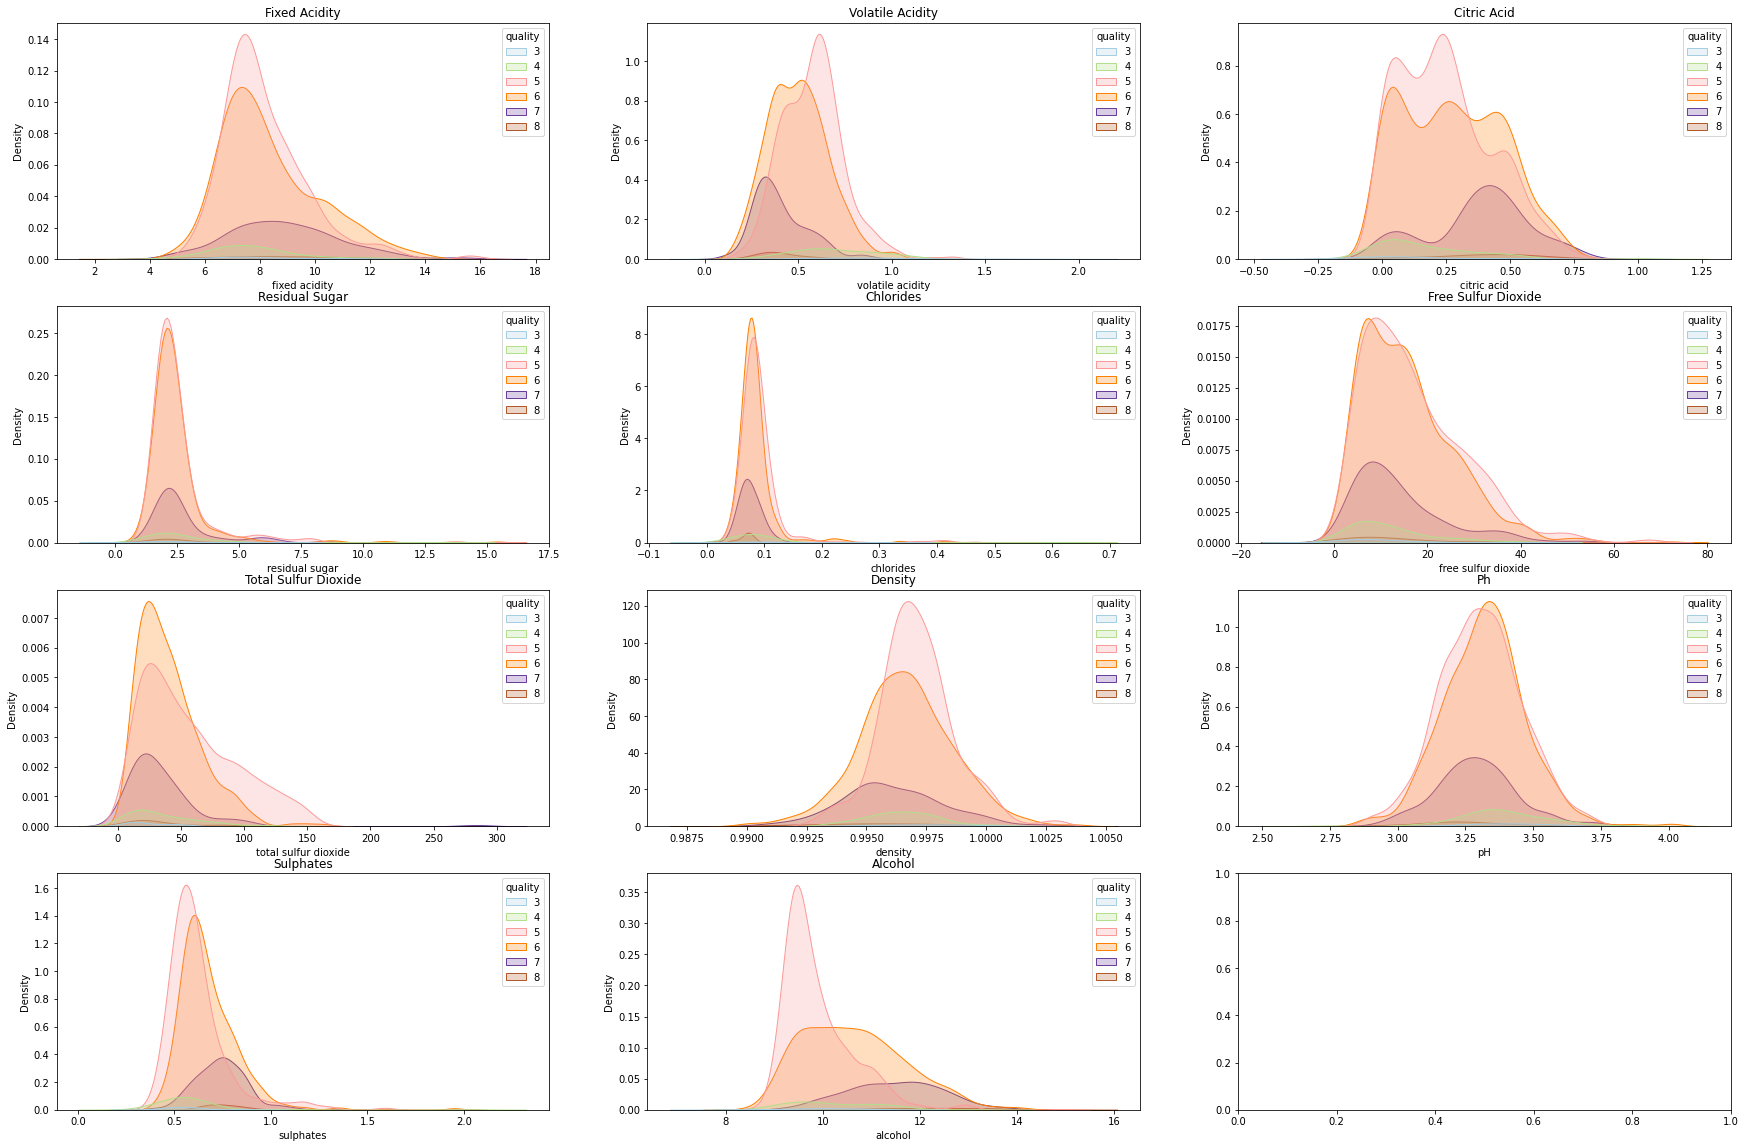

In [16]:
columns = [ col for col in dataframe.columns if col not in ['quality'] ]
n_cols = 3
n_rows = ceil(len(columns) / n_cols)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(10 * n_cols, 5 * n_rows))
for index, col in enumerate(columns):
  ax = axes[index // n_cols, int(index % n_cols)]
  sns.kdeplot(data=dataframe, x=col, ax=ax, fill=True, hue='quality', palette=sns.color_palette('Paired', len(columns), as_cmap=True))
  ax.set_title(col.title())

## Distribution of the values

Variability and distribution are really important, if our variability is almost non-existant, then we might aswell not consider a feature as a candidate.

Distribution helps us identify the quantity of the variability, in human words, of each value, how many data do we have.

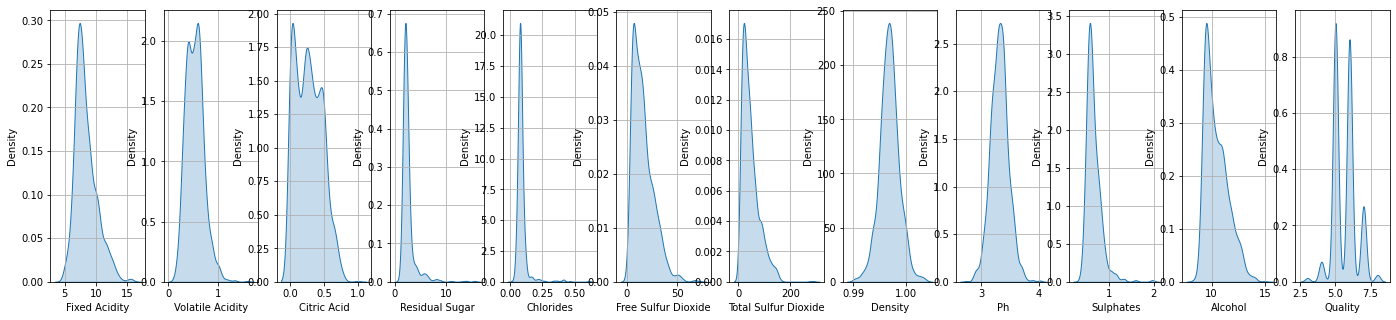

In [17]:
center_output()

columns = [ col for col in dataframe.columns if col not in [] ]
n_columns = len(dataframe.columns)
fig, axes = plt.subplots(1, n_columns, figsize=(2 * n_columns, 5))
for index, col in enumerate(columns):
  ax = axes[int(index % n_columns)]
  ax.grid()
  sns.kdeplot(data=dataframe, x=col, ax=ax, fill=True)
  ax.set_xlabel(col.title())

Boxplot not only shows us the distribution and it's percentil stacking, another useful insight, it can let us know the amount of outliers (values out of our scope or so to say, maths).

Having outliers adds value (real world value), because it's information that our model is not used to, so it'll help us shape a better model.

Straight from: https://towardsdatascience.com/exploratory-data-analysis-8fc1cb20fd15
By [Prasad Patil](https://medium.com/@theprasadpatil)

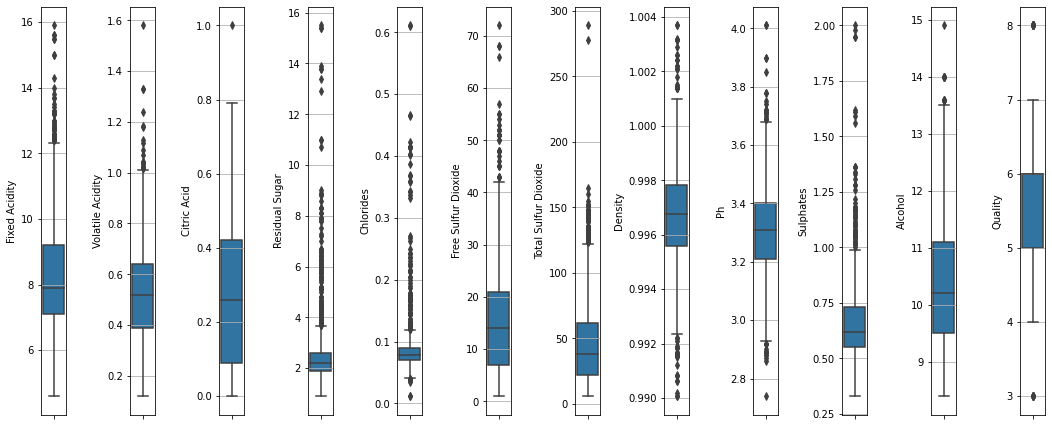

In [18]:
center_output()

columns = [ col for col in dataframe.columns if col not in [] ]
n_columns = len(dataframe.columns)
fig, axes = plt.subplots(1, n_columns, figsize=(1.5 * n_columns, 7.5))
plt.subplots_adjust(wspace=2.5)
for index, col in enumerate(columns):
  ax = axes[int(index % n_columns)]
  ax.grid()
  sns.boxplot(data=dataframe, y=col, ax=ax)
  ax.set_ylabel(col.title())

## Distribution of the quality

Observing the distribution it's a good practice, but, in classification problems, analyzing the the target feature, it's a must.

Either we're working with multiclass or binary classification, having an unbalanced dataset will result in a biased model. We may get a high score, but we'll be severely underperforming in the minority label, and minotiries have already suffered enough, so let's not contribute to that.

We do have an unbalanced dataset, we'll fix it later, but is a must that we do fix it.

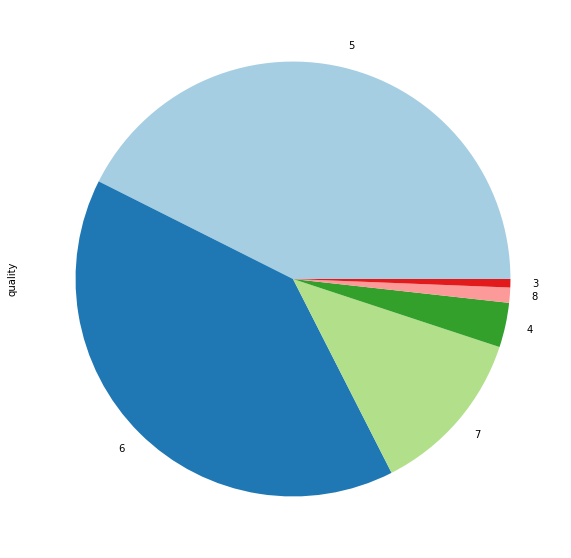

In [19]:
center_output()

plt.figure(figsize=(20, 10))
_ = dataframe['quality'].value_counts().plot.pie(
  colors=sns.color_palette('Paired')
)

We can observe a clear imbalancement. Multilabel Classifiers work by creating a classifier for each label, having that little amount of elements on some classes is going to add bias to our model and make it underperform, when it really shouldn't.

## Hypothesis

As aforementioned, we can now try to see some hypothesis, we saw the correlation and the shapes, mostly the correlation. So we can now plot in detail some values to see how they contribute to the target feature.

I've used integers as to, not only increase the performance, but to have a clearer shape, with integers we have less detail so it's clearer to see what's going on.

### Alcohol as a contributor

We saw alcohol as the highest correlated value with the target feature, we can merge some plots to see it's evolution.

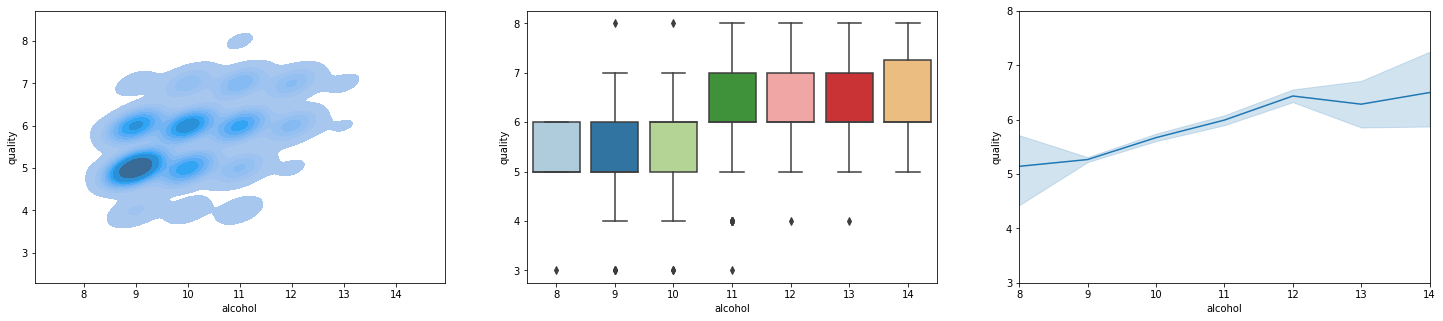

In [20]:
fig, axes = plt.subplots(1, 3, figsize=(25, 5))
# plt.grid()
plt.ylim(3, 8)
plt.xlim(8, 14)
palette = sns.color_palette('Paired', len(columns), as_cmap=True)
sns.kdeplot(data=dataframe.astype('int'), x='alcohol', fill=True, y='quality', palette=palette, ax=axes[0])
sns.boxplot(data=dataframe.astype('int'), x='alcohol', y='quality', palette=sns.color_palette('Paired'), ax=axes[1])
sns.lineplot(data=dataframe.astype('int'), x='alcohol', y='quality', ax=axes[2])

There's some sort of upwards correlation, it indicates that, alcohol is a must in a good wine, but not too much, still, the more alcohol, the better quality.

### Volatily acidity as a contributor

We'll do as we did with the alcohol, but since this one works with values between 0 and 1, using floats on the KDE almost breaks it's entire purpose because of the amount of information loss

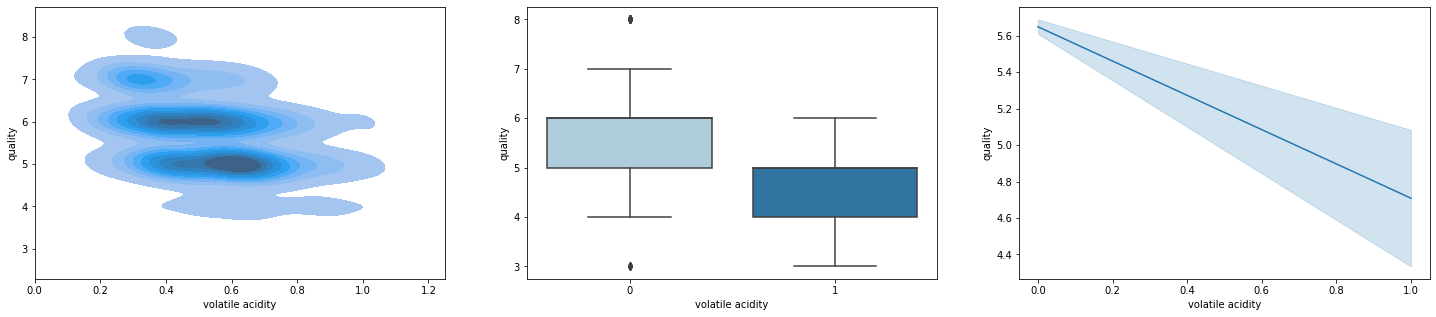

In [21]:
fig, axes = plt.subplots(1, 3, figsize=(25, 5))
# plt.grid()
# plt.ylim(3, 8)
axes[0].set_xlim(0, 1.25)
palette = sns.color_palette('Paired', len(columns), as_cmap=True)
sns.kdeplot(data=dataframe, x='volatile acidity', fill=True, y='quality', palette=palette, ax=axes[0])
sns.boxplot(data=dataframe.astype('int'), x='volatile acidity', y='quality', palette=sns.color_palette('Paired'), ax=axes[1])
sns.lineplot(data=dataframe.astype('int'), x='volatile acidity', y='quality', ax=axes[2])

This time around, the correlation is straight, literally, but that's because it's a binary plot, still, it did prove that the volatily acidity has an inverse correlation the more it has, the less quality the wine is.

# Data Science

While data science is more the alogirthmic and tuning part, assigning the values, feature selection, and imbalancement sampling/fixing it's also really important.

I've decided to break it into two sections as to better group sort of idfferent things

## Imports

Scalers are normalization methods, each for a different purpose, Standard is a good one, but MinMax fits better our dataset, since minmax contemplates outliers far better than the standard one does.

And pipelines are meant to ease the data preparation and model training

In [22]:
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler

## Data Assignment

Our training features and the target feature.

But first of all, we'll need to execute the first step to fix the imbalancement, which is to create a threshold between good and bad wines

In [23]:
temp_df = dataframe.copy(deep=True)
# Recomended by the official dataset
temp_df['quality'] = np.where(temp_df['quality'] >= 6.5, 1, 0)

Then we'll select only the features that we want, which, in our case, we'll be all but the target feature

In [24]:
target = 'quality'
ignore = [
  target,
#  'residual sugar',
#  'chlorides',
]
feature_names = [ col for col in temp_df.columns if col not in ignore ]

And we assign them

In [25]:
X = temp_df[feature_names]
y = temp_df[target]

## Data Imbalancement

Imbalancement happens when our target feature has an uneven distribution with a minority label, not to have equal number of label values is sort of okay, but when that breach grows bigger, we'll fall under a biased result.

You can toggle the following variable to see how the models perform with unbalanced data. I'd recomend to leave it at balanced dataset

In [26]:
BALANCE_DATASET = True #@param {type: 'boolean'}

We can see it clearly that there are more instances of bad wine than there are of good ones. While it may be a reality, we need to "teach" our model that there's an equal amount so that it can truly learn the difference.

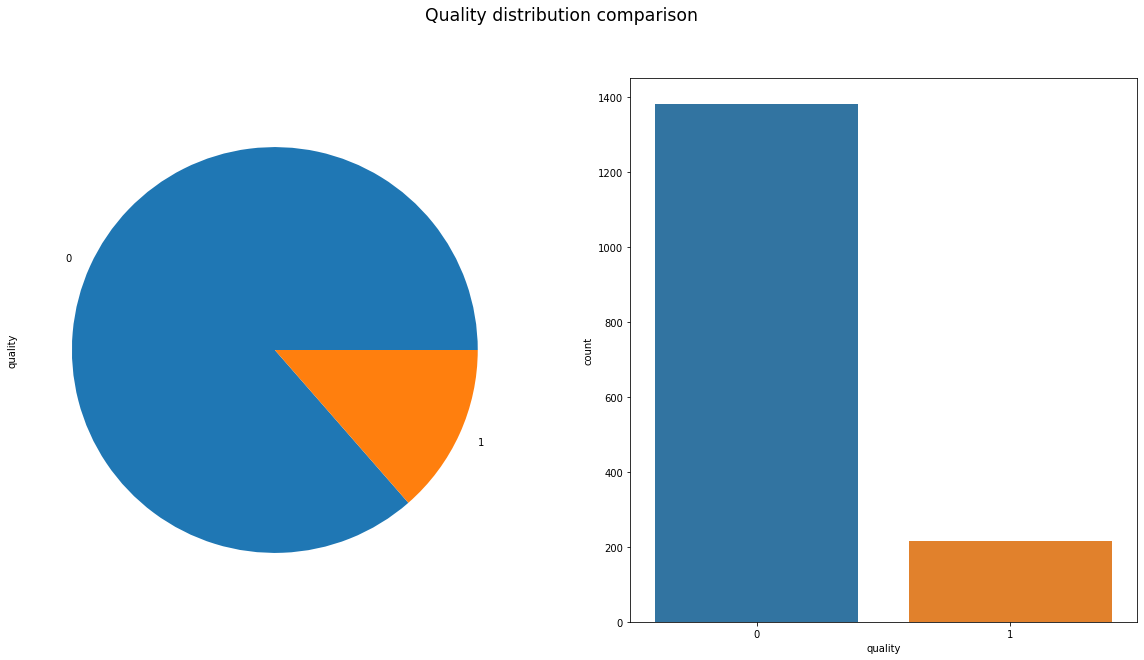

In [27]:
center_output()
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle('Quality distribution comparison', fontsize='xx-large')
y.value_counts().plot.pie(ax=axes[0])
_ = sns.countplot(x=y, ax=axes[1])

For that, we'll use an undersampling technique, which removes values at random from the majority label(s)

In [28]:
from imblearn.under_sampling import RandomUnderSampler

X_undersampled, y_undersampled = RandomUnderSampler(random_state=RANDOM_SEED).fit_resample(X, y)

In [29]:
if BALANCE_DATASET:
  X = X_undersampled
  y = y_undersampled

So that we can have a balanced result

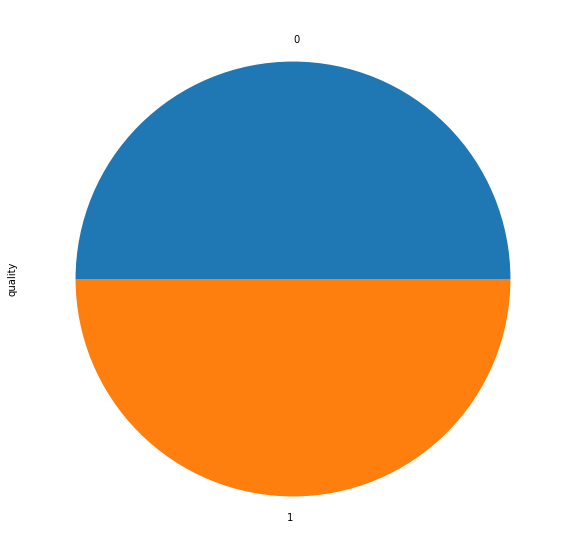

In [30]:
if BALANCE_DATASET:
  center_output()
  plt.figure(figsize=(20, 10))
  y.value_counts().plot.pie()

## Train and Test Split

We'll just split the values between a training set (that should be the biggest) and a test (production) set with data that our model hasn't seen before.

While being conscious of splitting properly our minority class.

In [31]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=RANDOM_SEED, stratify=y)

We could leave an unbalanced test set, but, in my opinion, testing the model with a balanced dataset allows us to see how trully well our model performs.

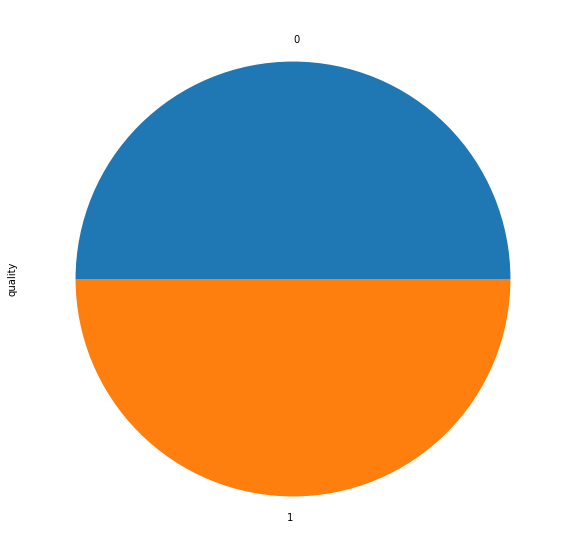

In [32]:
if BALANCE_DATASET:
  X_test, y_test = RandomUnderSampler(random_state=RANDOM_SEED).fit_resample(X_test, y_test)

  center_output()
  plt.figure(figsize=(20, 10))
  y_test.value_counts().plot.pie()

# Algorithms

The fun part, choosing the right technique and tuning it, in our case, I've chosen four techniques.

Two are supervised (Logistic and SVC) while two are unsupervised (Random Forest and XGBoost)

## Imports

For this final section, only metrics could be required. While not necessary for our models, they help us evaluate it's results.

In [33]:
from sklearn.metrics import balanced_accuracy_score, confusion_matrix, classification_report, roc_auc_score

## Helpers

Same as before, not necessary by any means, but they help reduce code duplicity

### Model Builder

We know that MinMax is the way to go, but we could also try out how does the standar scaler perform (which performs better only on the Logistic Regression).

So we can unify that logic under a pipeline, this way, whenever some set is passed, it will be normalized and then trained/evaluated, no mistakes involved.

In [34]:
def build_model(
  estimator,
) -> Pipeline:
  return Pipeline(
  steps=[
    ('scaler', MinMaxScaler()),
    ('algorithm', estimator),
  ]
)

### Confusion Matrix

The score can be deceiving, specially f1 score, so, having a normalized confusion matrix can help us identify how well are our models performing.

I've also went ahead and added a classification report and the AUC Score evaluation to see as much detail as possible. The idea is to see how our model is performing on the different labels, not only the overall accuracy.

In [35]:
default_target_names = ['Bad', 'Good']

def cmatrix(
  y_true: pd.DataFrame,
  y_pred: pd.DataFrame,
  target_names: List[str] = default_target_names,
  y_probas: np.array = None
) -> None:
  df_cm = confusion_matrix(y_true, y_pred)
  df_cm = df_cm.astype('float') / df_cm.sum(axis = 1)[:, np.newaxis]
  plt.figure(figsize=(20, 10))
  default_params = {
    'square': True,
    'annot': True,
    'cbar': True,
    'cbar_kws': {'orientation': 'horizontal'},
    'annot_kws': { 'fontsize': 13 },
    'cmap': 'Blues',
  }
  sns.heatmap(df_cm, **default_params, xticklabels=target_names, yticklabels=target_names)
  plt.show()
  creport = classification_report(y_true, y_pred, target_names=target_names)
  print('')
  print('Classification Report')
  print('')
  print(creport)
  if y_probas is not None:
    print(f'AUC Score: {round(roc_auc_score(y_true, y_probas), 2)}')
  print('')

## Logarithmic Regression

Also called logistic regression, it's the linear regression with a logistic function applied to the outcome, it works with a decission boundary (a line) that decide wether a value is one thing or the other, in our case, wether it's a good wine or not.

If we were to be working with multiclass classification, we'd have, under the hood, multiple classificators, hence why having a balanced dataset and a good distribution is sooo important, we'd have classificators trained with hunders of values while others would be trained with only a handfull of values.

In [36]:
from sklearn.linear_model import LogisticRegression

clf_log = build_model(LogisticRegression(random_state=RANDOM_SEED))
clf_log.fit(X_train, y_train)
y_pred_log = clf_log.predict(X_test)

print(clf_log.score(X_test, y_test))
print(balanced_accuracy_score(y_test, y_pred_log))

0.7441860465116279
0.7441860465116279


### Confusion Matrix

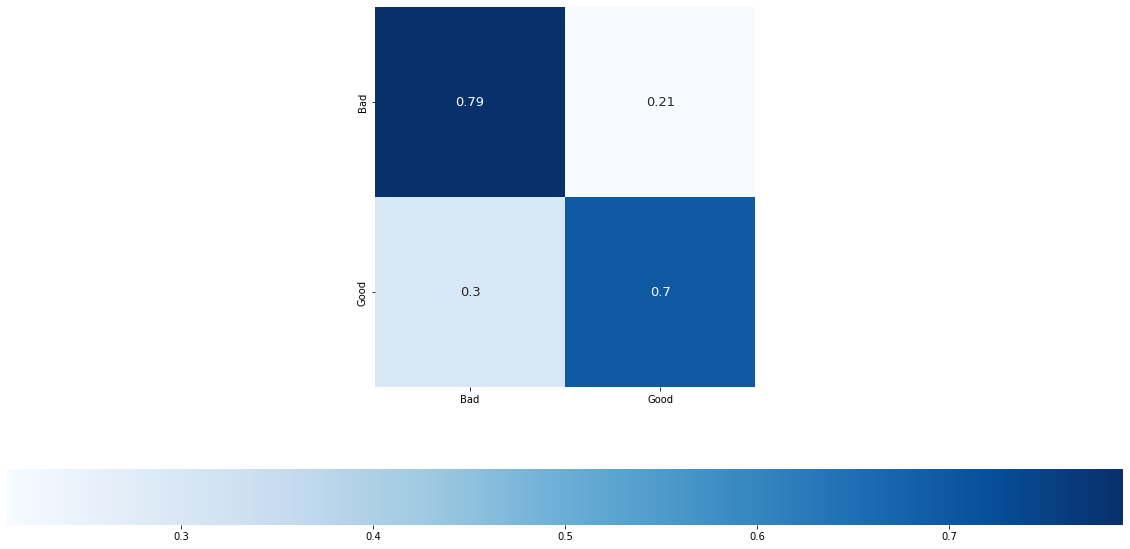


Classification Report

              precision    recall  f1-score   support

         Bad       0.72      0.79      0.76        43
        Good       0.77      0.70      0.73        43

    accuracy                           0.74        86
   macro avg       0.75      0.74      0.74        86
weighted avg       0.75      0.74      0.74        86

AUC Score: 0.83



In [37]:
center_output()
cmatrix(y_test, y_pred_log, y_probas=clf_log.predict_proba(X_test)[:,1])

### Explained

We can explain it's coefficients to see what contributes and how to the value.

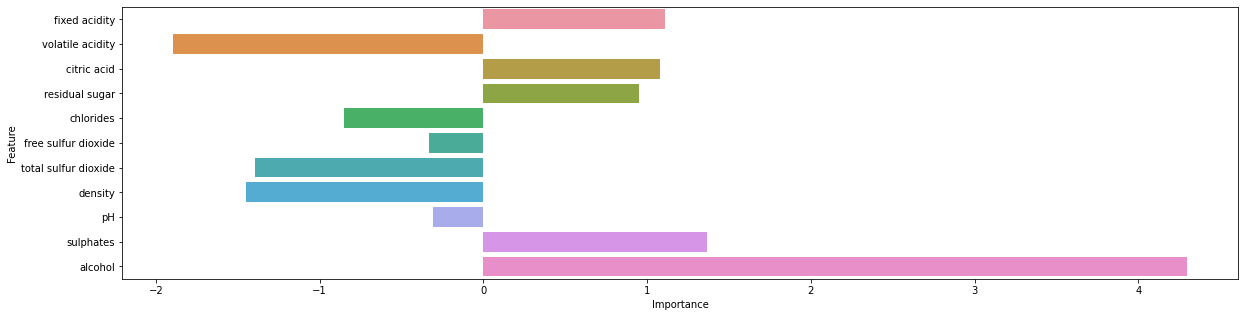

In [38]:
df_features_log = pd.DataFrame(
  zip(feature_names, clf_log['algorithm'].coef_[0]),
  columns=['Feature', 'Importance'],
)
center_output()
plt.figure(figsize=(20, 5))
_ = sns.barplot(data=df_features_log, y='Feature', x='Importance')

## Random Forest

A forest of decission trees that chooses it's best version, it uses ensemble to choose which model is actually performing better. It's powerfull, but you have to trust that it's doing it the right way because you can't really explain it's process

In [39]:
from sklearn.ensemble import RandomForestClassifier

clf_rf = build_model(RandomForestClassifier(random_state=RANDOM_SEED))
clf_rf.fit(X_train, y_train)
y_pred_rf = clf_rf.predict(X_test)

print(clf_rf.score(X_test, y_test))
print(balanced_accuracy_score(y_test, y_pred_rf))

0.813953488372093
0.813953488372093


### Confusion Matrix

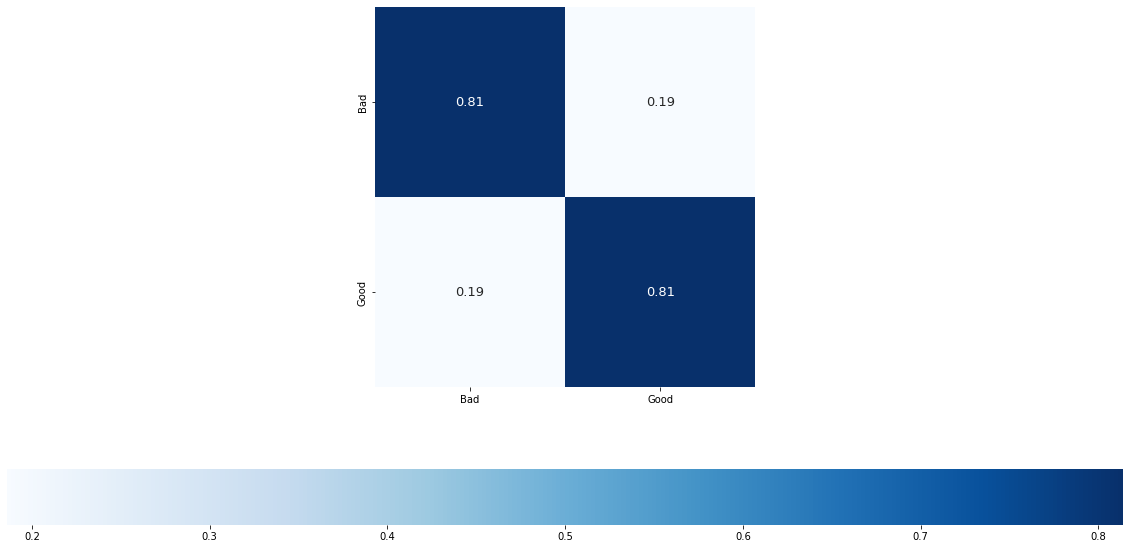


Classification Report

              precision    recall  f1-score   support

         Bad       0.81      0.81      0.81        43
        Good       0.81      0.81      0.81        43

    accuracy                           0.81        86
   macro avg       0.81      0.81      0.81        86
weighted avg       0.81      0.81      0.81        86

AUC Score: 0.85



In [40]:
center_output()
cmatrix(y_test, y_pred_rf, y_probas=clf_rf.predict_proba(X_test)[:,1])

### Explained

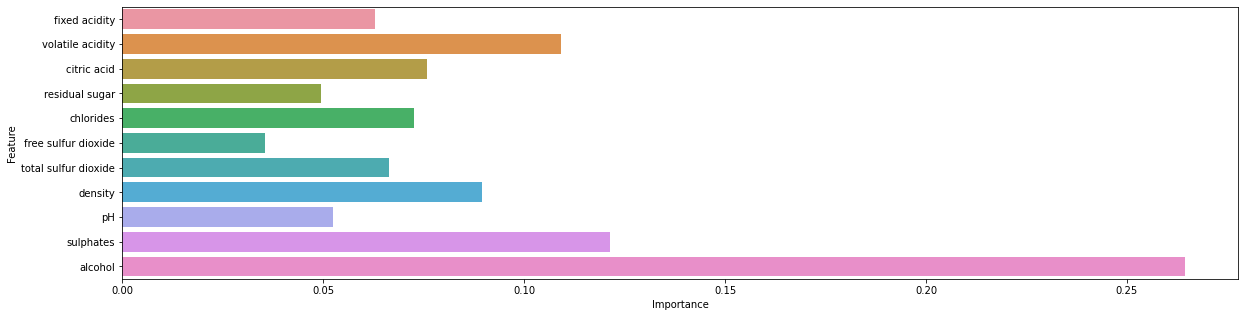

In [41]:
df_features_rf = pd.DataFrame(
  zip(feature_names, clf_rf['algorithm'].feature_importances_),
  columns=['Feature', 'Importance'],
)
center_output()
plt.figure(figsize=(20, 5))
_ = sns.barplot(data=df_features_rf, y='Feature', x='Importance')

## Support Vector Machine

It creates hyperplanes that, for our intents and purposes, can be solved with a linear regression, so... we divide the problem into easier subproblems, and we solve them.

We're using the `C` param as too add regularization, which helps us perform better on unseen data by not performing to it's fullest on the training data. It helps to avoid overfitting.

In [42]:
from sklearn.svm import SVC

clf_svc = build_model(SVC(random_state=RANDOM_SEED, C=2.0, kernel='linear', probability=True))
clf_svc.fit(X_train, y_train)
clf_svc.score(X_test, y_test)
y_pred_svc = clf_svc.predict(X_test)

print(clf_svc.score(X_test, y_test))
print(balanced_accuracy_score(y_test, y_pred_svc))

0.7558139534883721
0.7558139534883721


### Confusion Matrix

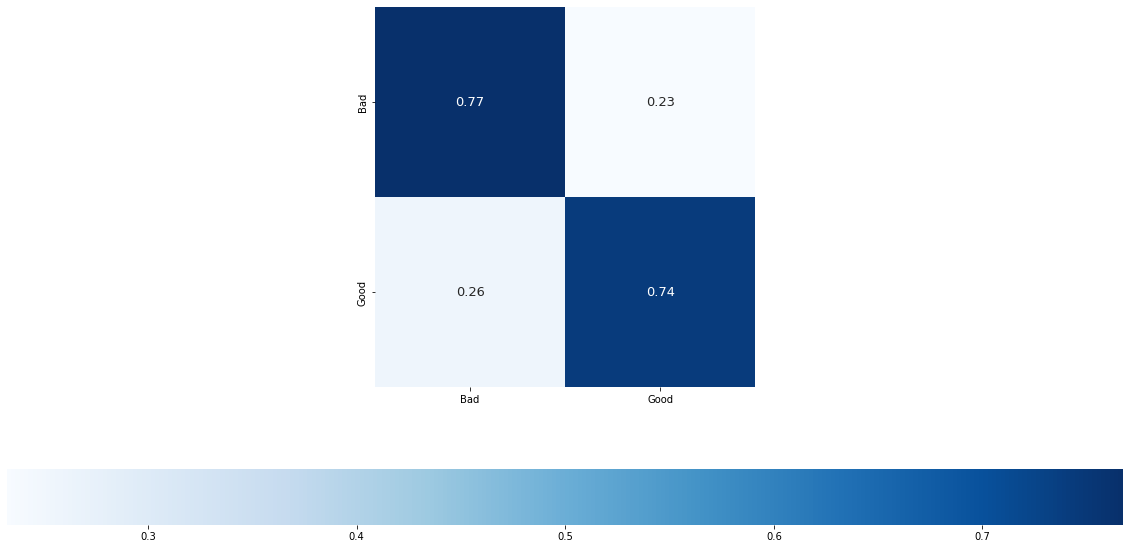


Classification Report

              precision    recall  f1-score   support

         Bad       0.75      0.77      0.76        43
        Good       0.76      0.74      0.75        43

    accuracy                           0.76        86
   macro avg       0.76      0.76      0.76        86
weighted avg       0.76      0.76      0.76        86

AUC Score: 0.82



In [43]:
center_output()
cmatrix(y_test, y_pred_svc, y_probas=clf_svc.predict_proba(X_test)[:,1])

### Explained

Once again, using a supervised model, we can explain it's coefficients

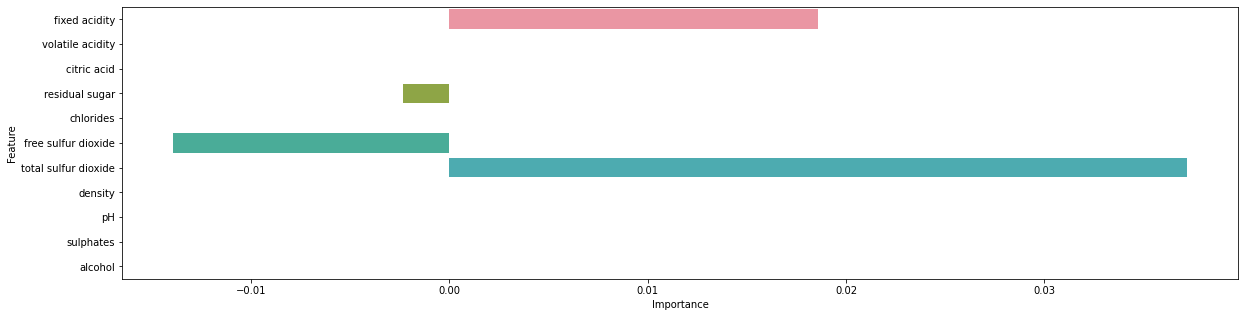

In [44]:
from sklearn.inspection import permutation_importance
import warnings
warnings.filterwarnings('ignore')

df_features_svc = pd.DataFrame(
  zip(feature_names, permutation_importance(clf_svc['algorithm'], X_test, y_test).importances_mean),
  columns=['Feature', 'Importance'],
)
center_output()
plt.figure(figsize=(20, 5))
_ = sns.barplot(data=df_features_svc, y='Feature', x='Importance')

warnings.filterwarnings('default')

## XGBoost

A gradient boosted regularized technique, really popular nowadays (which is when I'm starting). But we can't truly explain how it's working.

In [45]:
from xgboost import XGBClassifier

clf_xgboost = build_model(XGBClassifier(
  random_state=RANDOM_SEED,
  objective='binary:logistic',
))
clf_xgboost.fit(X_train, y_train)
clf_xgboost.score(X_test, y_test)
y_pred_xgboost = clf_xgboost.predict(X_test)

print(clf_xgboost.score(X_test, y_test))
print(balanced_accuracy_score(y_test, y_pred_xgboost))

0.813953488372093
0.813953488372093


### Confusion Matrix

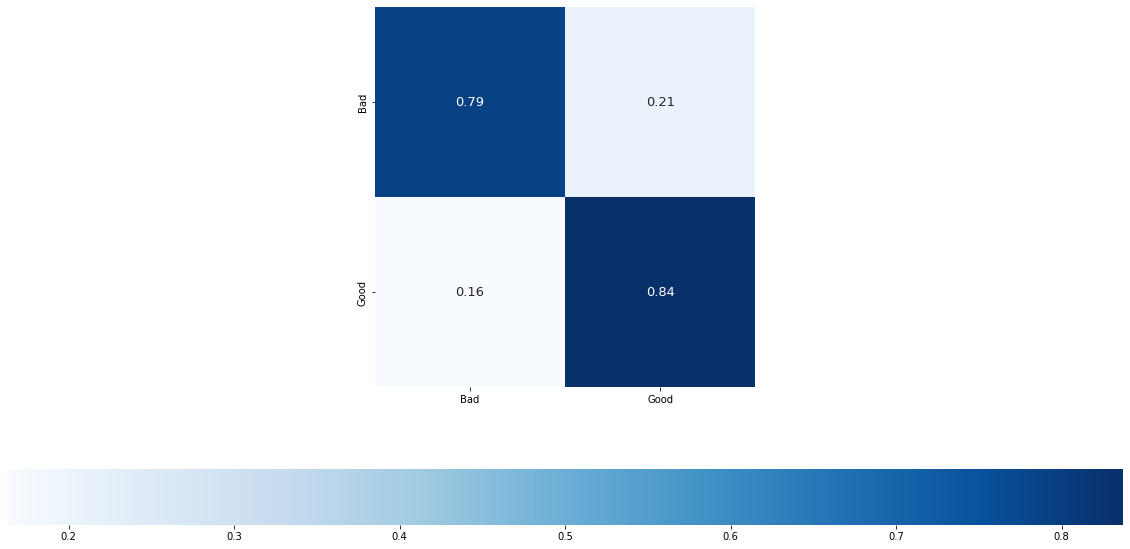


Classification Report

              precision    recall  f1-score   support

         Bad       0.83      0.79      0.81        43
        Good       0.80      0.84      0.82        43

    accuracy                           0.81        86
   macro avg       0.81      0.81      0.81        86
weighted avg       0.81      0.81      0.81        86

AUC Score: 0.82



In [46]:
center_output()
cmatrix(y_test, y_pred_xgboost, y_probas=clf_xgboost.predict_proba(X_test)[:,1])

### Explained

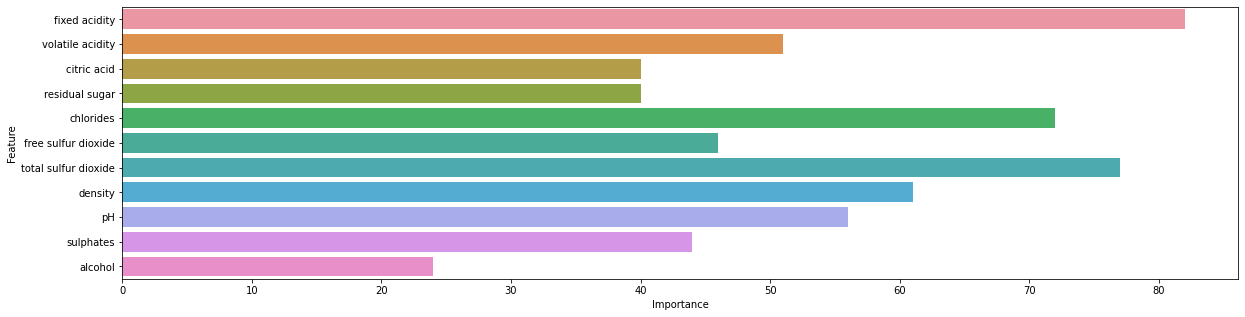

In [47]:
df_xgboost_importances = pd.DataFrame(
  zip(feature_names, clf_xgboost['algorithm'].get_booster().get_score().values()),
  columns=['Feature', 'Importance']
)
center_output()
plt.figure(figsize=(20, 5))
_ = sns.barplot(data=df_xgboost_importances, y='Feature', x='Importance')

# Conclusions

## Imbalancement

F1 score can be deceiving, specially on highly unbalanced datasets, the score is given by the ammount of failed and correctly classified values, if we evaluate our model with a biased model, it will work wonders on the majority class, but the minority will be underperforming.

Working with an unbalanced dataset will grant us a lower score, usually, but a much more balanced one at that, while we won't have a perfect score on the majority, we'll have a similar score on the majority and minority classes.

Balanced accuracy and AUC Score can give us a more real score when evaluating, those scores are usually the ones that matter most, specially the balanced accuracy, since, having a score above .8 it's considered a good classifier.

## Adequate algorithm

Random Forest would be the one that I'd choose as an overall score, it's not the one with the highest score per se, but it's the one the performs the best most consistently, and that's a result that I like better.

But, if I had to choose explainability over performance, without a second thought, SVM, Support Vector Machines are wonderfull, and we can explain them to a certain degree. Also, in this project, supervised vs unsupervised are not that far, yes, unsupervised performed better, but not for much

## What matters most for the quality of a wine

The alcohol of a wine, it's density and it's acidity, But almost everything matters, it's an equation not a two numbers computation.

It's not too far off from the hypothesis, but tuning and training the model gave us some insights.

# The end!!

Thus, concluding the notebook, I hope you learned some new things, I sure did, and the importance of unbalancement, while not having a higher score may make you feel like less competent, or that you're not doing it as well as others. 

Balancement is important, "sacrifice" that score, because, in reality, it was always lower.